<a href="https://colab.research.google.com/github/BOUBEGHELRima/Anomaly_detection/blob/main/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('/content/ec2_cpu_utilization_24ae8d.csv')

# Select the specific column for forecasting
column_name = 'value'
data = dataset[['timestamp', column_name]]

# Convert the Time column to datetime if it's not already
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

data = data.iloc[:3500]

# Fill missing values
data[column_name].fillna(method='ffill', inplace=True)


In [64]:
data

,value
timestamp,
2014-02-14 14:30:00,0.132
2014-02-14 14:35:00,0.134
2014-02-14 14:40:00,0.134
2014-02-14 14:45:00,0.134
2014-02-14 14:50:00,0.134
...,...
2014-02-26 17:45:00,0.134
2014-02-26 17:50:00,0.134
2014-02-26 17:55:00,0.134


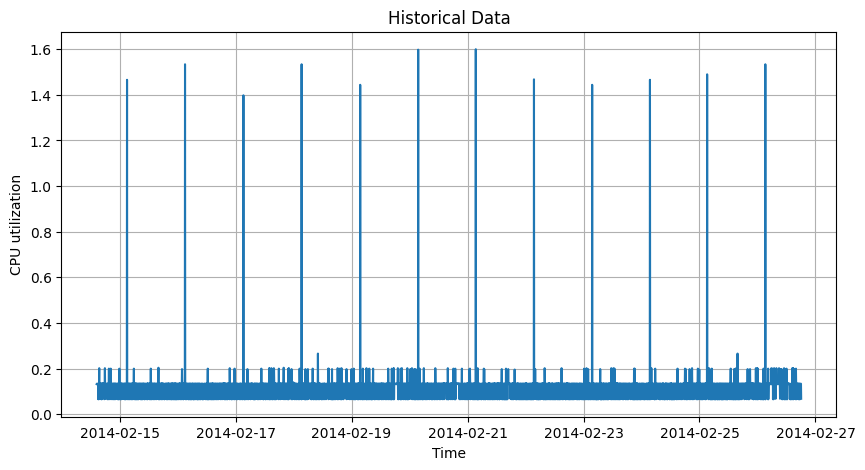

In [65]:
# Plot the selected data
plt.figure(figsize=(10, 5))
plt.plot(data.index, data[column_name])
plt.title('Historical Data')
plt.xlabel('Time')
plt.ylabel('CPU utilization')
plt.grid(True)
plt.show()

In [66]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3500 entries, 2014-02-14 14:30:00 to 2014-02-26 18:05:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   3500 non-null   float64
dtypes: float64(1)
memory usage: 54.7 KB


In [67]:
import joblib

# Function to create a dataset as required by LSTM
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Use a look_back period suitable for a daily forecast
look_back = 24
X, y = create_dataset(data[[column_name]].values, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))


In [68]:
X

array([[[0.132, 0.134, 0.134, ..., 0.134, 0.134, 0.066]],

       [[0.134, 0.134, 0.134, ..., 0.134, 0.066, 0.134]],

       [[0.134, 0.134, 0.134, ..., 0.066, 0.134, 0.134]],

       ...,

       [[0.2  , 0.134, 0.132, ..., 0.132, 0.134, 0.134]],

       [[0.134, 0.132, 0.066, ..., 0.134, 0.134, 0.134]],

       [[0.132, 0.066, 0.134, ..., 0.134, 0.134, 0.134]]])

In [69]:
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Split the data into train and test sets
train_size = int(len(X) * 0.80)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

# Create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(1, look_back), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 100)            50000     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 100)            80400     
                                                                 
 dropout_3 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                30200     
                                                                 
 dense_8 (Dense)             (None, 32)                1632      
                                                                 
 dense_9 (Dense)             (None, 1)                

In [70]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# Adjust learning rate
optimizer = Adam(learning_rate=0.001)
cp1= ModelCheckpoint('/content/best_model.h5', monitor='val_loss', save_best_only=True)

# Compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['RootMeanSquaredError'])

# Train for more epochs
model.fit(trainX, trainY, epochs=1000, batch_size=64, validation_data=(testX, testY), callbacks=[cp1])


Epoch 1/1000
44/44 [==============================] - 9s 46ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 2/1000
13/44 [=======>......................] - ETA: 0s - loss: 0.0058 - root_mean_squared_error: 0.0759

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 1s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0884 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 3/1000
44/44 [==============================] - 0s 11ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0814
Epoch 4/1000
44/44 [==============================] - 1s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0815
Epoch 5/1000
44/44 [==============================] - 0s 11ms/step - loss: 0.0079 - root_mean_squared_error: 0.0887 - val_loss: 0.0067 - val_root_mean_squared_error: 0.0817
Epoch 6/1000
44/44 [==============================] - 1s 13ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0066 - val_root_mean_squared_error: 0.0813
Epoch 7/1000
44/44 [==============================] - 1s 12ms/step - loss: 0.0078 - root_mean_squared_error: 0.0885 - val_loss: 0.0067 - val_root_me

22/22 [==============================] - 0s 4ms/step


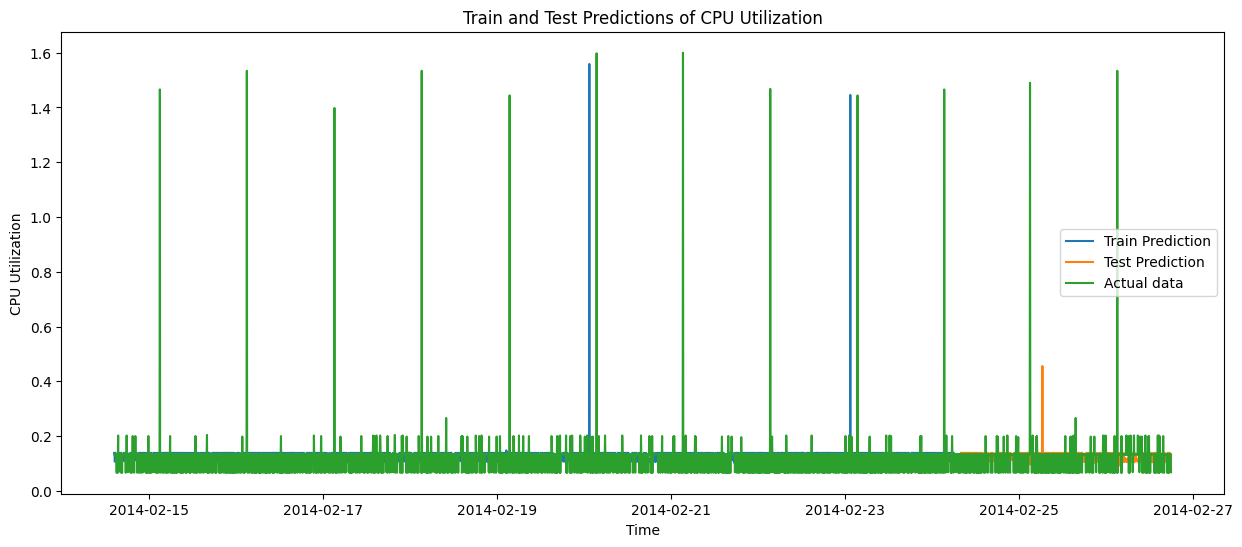

In [71]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Plotting Train and Test Predictions
plt.figure(figsize=(15, 6))
plt.plot(data.index[:len(trainPredict)], trainPredict, label='Train Prediction')
plt.plot(data.index[len(trainPredict) + look_back:], testPredict, label='Test Prediction')
plt.plot(data.index, data[column_name].values, label='Actual data')
plt.title('Train and Test Predictions of CPU Utilization')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.legend()
plt.show()


In [72]:
np.save('test.npy', testX)

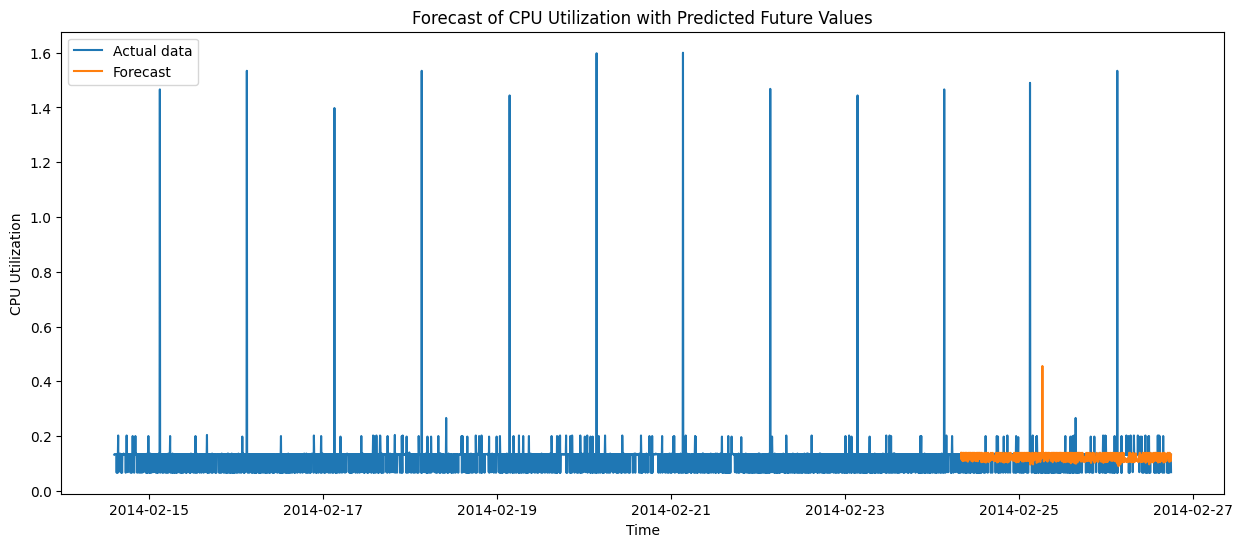

In [73]:
# Plotting Forecast of CPU Utilization with predicted future values
forecastPlot = np.empty_like(data[column_name].values)
forecastPlot[:] = np.nan
forecastPlot[len(trainPredict) + look_back:len(trainPredict) + look_back + len(testPredict)] = testPredict.flatten()

plt.figure(figsize=(15, 6))
plt.plot(data.index, data[column_name].values, label='Actual data')
plt.plot(data.index, forecastPlot, label='Forecast')
plt.title('Forecast of CPU Utilization with Predicted Future Values')
plt.xlabel('Time')
plt.ylabel('CPU Utilization')
plt.legend()
plt.show()


In [74]:
len(testX)

696